# Preprocess

In [39]:
import json
import numpy as np

# 定义输入文件名
input_file_path = 'trajectories-0400-0415.json'

# 初始化最大最小值
min_timestamp, max_timestamp = float('inf'), float('-inf')
min_position, max_position = float('inf'), float('-inf')

# 遍历文件以找到最大最小值
with open(input_file_path, 'r') as file:
    for line in file:
        record = json.loads(line)
        timestamps = np.array(record['timestamp']) / 1000  # 将时间戳从毫秒转换为秒
        local_y_positions = np.array(record['local_y']) * 0.3048  # 将位置从英尺转换为米

        # 更新最大最小值
        min_timestamp = min(min_timestamp, timestamps.min())
        max_timestamp = max(max_timestamp, timestamps.max())
        min_position = min(min_position, local_y_positions.min())
        max_position = max(max_position, local_y_positions.max())

# 打印出找到的最大最小值（可选）
print(f"Timestamp range: {min_timestamp} - {max_timestamp}")
print(f"Position range: {min_position} - {max_position}")

Timestamp range: 1113433135.3 - 1113434136.5
Position range: 0.0 - 535.6823424


# Create grids

In [40]:
def get_grid(min_x, max_x, min_t, max_t, x_res, t_res):
    x_grid = np.arange(min_x, max_x + x_res, x_res).tolist()
    t_grid = np.arange(min_t, max_t + t_res, t_res).tolist()
    return x_grid, t_grid

# 使用找到的最大最小值生成网格
x_res, t_res = 10, 2  # 分辨率可以根据需要调整
x_grid, t_grid = get_grid(min_position, max_position, min_timestamp, max_timestamp, x_res, t_res)

# Distribute the data into grids

In [41]:
def compute_speed(record):
    timestamps = np.array(record['timestamp']) / 1000  # 将时间戳从毫秒转换为秒
    local_y_positions = np.array(record['local_y']) * 0.3048  # 将位置从英尺转换为米
    
    sorted_indices = np.argsort(timestamps)
    timestamps = timestamps[sorted_indices]
    local_y_positions = local_y_positions[sorted_indices]

    timestamps += 9 * 3600  # 调整时间（向前移动9个小时）

    speed = np.diff(local_y_positions) / np.diff(timestamps)
    speed = np.append(speed[0], speed)  # 保持速度数组与位置数组长度一致
    speed *= 2.23694  # 将速度从 m/s 转换为 mph
    
    return timestamps, local_y_positions, speed

def grid_traj(record, x_grid, t_grid, x_t_speed_dict, x_t_density_dict):
    timestamps, positions, speed = compute_speed(record)
    
    t_grid_ind, data_ind = 0, 0
    
    while data_ind < len(timestamps):
        while t_grid_ind < len(t_grid) - 1 and timestamps[data_ind] >= t_grid[t_grid_ind + 1]:
            t_grid_ind += 1
        
        for i in range(len(x_grid) - 1):
            if positions[data_ind] >= x_grid[i] and positions[data_ind] < x_grid[i + 1]:
                key = (x_grid[i], t_grid[t_grid_ind])
                if key not in x_t_speed_dict:
                    x_t_speed_dict[key] = []
                    x_t_density_dict[key] = 0
                x_t_speed_dict[key].append(speed[data_ind])
                x_t_density_dict[key] += 1
        
        data_ind += 1

# 初始化全局速度和密度字典
global_x_t_speed_dict = {}
global_x_t_density_dict = {}

# 重新遍历文件，处理每一条数据
with open(input_file_path, 'r') as file:
    i = 0
    for line in file:
        record = json.loads(line)
        grid_traj(record, x_grid, t_grid, global_x_t_speed_dict, global_x_t_density_dict)
        i += 1
        if i % 200 == 0 :
            print(f"Process {i} vehicles")
    print("Complete!")

Process 200 vehicles
Process 400 vehicles
Process 600 vehicles
Process 800 vehicles
Process 1000 vehicles
Process 1200 vehicles
Process 1400 vehicles
Process 1600 vehicles
Process 1800 vehicles
Process 2000 vehicles


# Plot each vehicle

Earliest timestamp: 2005-04-14 15:58:55
Latest timestamp: 2005-04-14 16:15:37


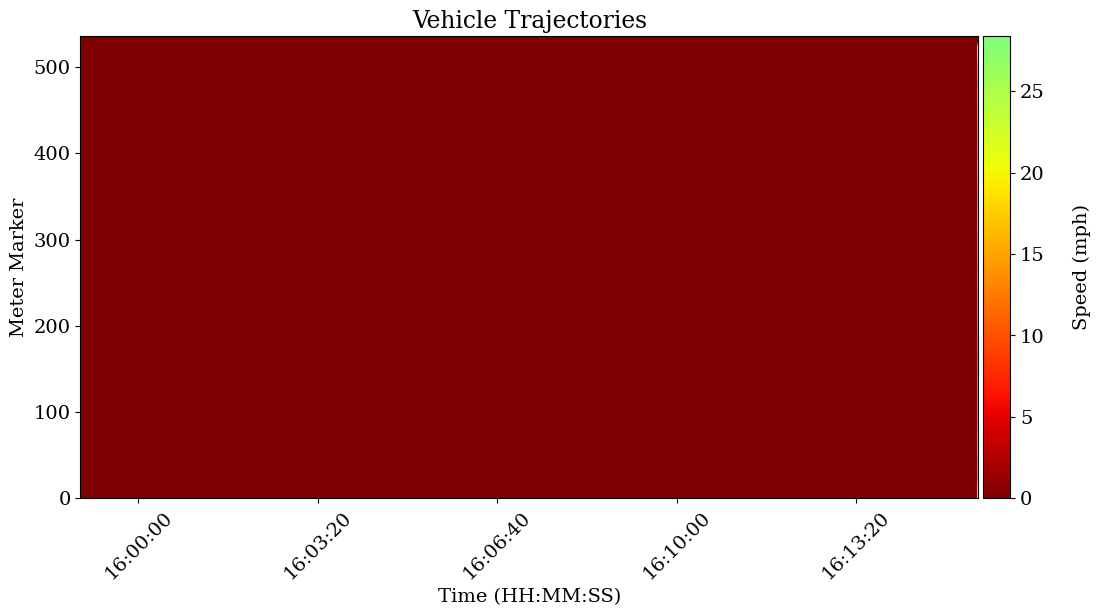

In [42]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
import datetime

def plot_trajectory(title, x_res=10, t_res=2, plot_density=False):
    plt.rc('font', family='serif', size=14)
    fig, ax = plt.subplots(figsize=(12, 6))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    jet = plt.cm.jet
    colors = [jet(x) for x in np.linspace(1, 0.5, 256)]
    green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

    if plot_density:
        data = np.array([[global_x_t_density_dict.get((x, t), 0) for t in t_grid] for x in x_grid])
        label = 'Density'
    else:
        data = np.array([[np.mean(global_x_t_speed_dict.get((x, t), [0])) if global_x_t_speed_dict.get((x, t)) else 0 for t in t_grid] for x in x_grid])
        label = 'Speed (mph)'
        data = np.clip(data, 0, 55)  # 将速度限制在 0 到 55 mph

    # 调整时间轴和位置轴的范围
    extent = [min_timestamp + 9 * 3600, max_timestamp + 9 * 3600, min_position, max_position]
    im = ax.imshow(data, cmap=green_to_red, aspect='auto', origin='lower', extent=extent)

    plt.colorbar(im, cax=cax).set_label(label, rotation=90, labelpad=20)
    ax.set_xlabel("Time (HH:MM:SS)")
    ax.set_ylabel("Meter Marker")
    ax.set_title(title)

    # 调整x轴时间格式
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    x_datetime = [datetime.datetime.fromtimestamp(ts) for ts in ticks_loc]
    labels = [d.strftime('%H:%M:%S') for d in x_datetime]
    ax.set_xticklabels(labels, rotation=45)

    # 打印最早和最晚的时间戳
    earliest_time = datetime.datetime.fromtimestamp(min(t_grid) + 9 * 3600).strftime('%Y-%m-%d %H:%M:%S')
    latest_time = datetime.datetime.fromtimestamp(max(t_grid) + 9 * 3600).strftime('%Y-%m-%d %H:%M:%S')
    print(f"Earliest timestamp: {earliest_time}")
    print(f"Latest timestamp: {latest_time}")

    plt.show()

# 调用绘图函数
plot_trajectory('Vehicle Trajectories', x_res=10, t_res=2)